In [1]:
import sys
sys.path.append('../recommender/')
import background_remover as br
from cloth_detector import *
import KNN_indexer as indexer
import gram_extractor as ge
import item_collector as ic
import uuid
from io import BytesIO
from os.path import exists
from os import remove, makedirs
from shutil import move
from pathlib import Path

image_path_temp = Path("../static/tmp")

In [3]:
os.makedirs(image_path_temp, exist_ok=True)
learner, id2cat, cat2id = load_learner()
index_dict = {}

for cat in cat2id.values():
    grams_fn = ic.get_grams_filename(cat)
    if exists(grams_fn):
        data = ic.get_grams_collection(cat)
        index_dict[cat] = indexer.get_index(cat, data)

ORIGINAL = "original_image"
CROPPED = "cropped_items"
CATS = "categories"
CHOSEN_IMAGE = "chosen_image"
CHOSEN_CAT = "chosen_cat"
ID2CAT = "id2cat"

def get_unique_filename():
    return f"{image_path_temp}/{uuid.uuid4()}.jpg"

def get_largest_index(scores):
    return scores.max(0)[1]

def get_largest_bbox(bboxes, largest_index, img_res):
    bb = bboxes[largest_index].squeeze()
    bb = scale_bbox(bb, img_res)
    return bb

def scale_bbox(bbox, res):
    h, w = res
    return np.array([bbox[1]*h, bbox[0]*w, bbox[3]*h, bbox[2]*w])

def get_results(fn, cat):
    gram = ge.get_gram(fn)
    return get_knn(index, act)[1]

def get_recommendations(chosen_json):
    img_fn = chosen_json[CHOSEN_IMAGE]
    cat = chosen_json[CHOSEN_CAT]
#     img.save(fn)
#     bboxes, cats, conf_scores = predict(learner, fn)
#     largest_index = get_largest_index(conf_scores)
#     cat = cats[largest_index][0]
    if cat in index_dict:
        br.remove_background(img_fn).save(img_fn)
        features_vector = ge.get_gram(img_fn)
        ids = indexer.get_knn(index_dict[cat], features_vector, k=4)[0]
        ar = ic.get_filenames_collection(cat)
        result = []
        for i in ids:
            result.append(ar[i])
    else:
        result = -1
    return result

def get_detected_items(img):
    org_fn = get_unique_filename()
    i_fns = []
    cat_list = []
    img.save(org_fn)
    bboxes, cats, _ = predict(learner, org_fn)
    for cat, bbox in zip(cats,bboxes):
        i_fn = get_unique_filename()
        bbox = scale_bbox(bbox, img.size)
        img.crop(tuple(bbox)).save(i_fn)
        i_fns.append(i_fn)
        cat_list.append(cat)
    return {CROPPED: i_fns,
            CATS: cat_list,
            ID2CAT: id2cat}


In [8]:
# get_detected_items(Image.open("../../files/files/TS02G02MBLK_M_1.jpg"))

{'cropped_items': ['../static/tmp/f7fdfe5f-b6cf-44ab-ab04-211de6153ead.jpg',
  '../static/tmp/d5d073c4-71b7-4c26-b3ca-0f815dd6ef77.jpg',
  '../static/tmp/3bfa6cf3-fa1c-4e22-84d2-4c5a4104efa5.jpg'],
 'categories': [3, 7, 8]}

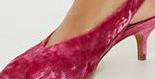

In [13]:
# Image.open("../static/tmp/f7fdfe5f-b6cf-44ab-ab04-211de6153ead.jpg")

In [14]:
# get_recommendations({CHOSEN_IMAGE: "../static/tmp/d5d073c4-71b7-4c26-b3ca-0f815dd6ef77.jpg",
#                     CHOSEN_CAT: 7})

array([3, 2, 4, 1], dtype=int32)